In [1]:
!pip install pandas numpy scikit-learn matplotlib



In [2]:
!wget https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
!unzip ml-latest-small.zip



--2025-08-10 13:55:13--  https://files.grouplens.org/datasets/movielens/ml-latest-small.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 978202 (955K) [application/zip]
Saving to: ‘ml-latest-small.zip’

ml-latest-small.zip 100%[===================>] 955.28K  4.28MB/s    in 0.2s    

2025-08-10 13:55:13 (4.28 MB/s) - ‘ml-latest-small.zip’ saved [978202/978202]

Archive:  ml-latest-small.zip
   creating: ml-latest-small/
  inflating: ml-latest-small/links.csv  
  inflating: ml-latest-small/tags.csv  
  inflating: ml-latest-small/ratings.csv  
  inflating: ml-latest-small/README.txt  
  inflating: ml-latest-small/movies.csv  


In [3]:
import pandas as pd

movies = pd.read_csv("ml-latest-small/movies.csv")
ratings = pd.read_csv("ml-latest-small/ratings.csv")

print("🎬 Movies:")
print(movies.head(), "\n")

print("⭐ Ratings:")
print(ratings.head())



🎬 Movies:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy   

⭐ Ratings:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [8]:
user_movie_matrix = ratings.pivot_table(
    index='userId',
    columns='movieId',
    values='rating'
)

user_movie_matrix = user_movie_matrix.fillna(0)

print(user_movie_matrix.head())
from sklearn.neighbors import NearestNeighbors

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_movie_matrix)

def get_similar_users(user_id, n_neighbors=5):
    user_vector = user_movie_matrix.loc[user_id].values.reshape(1, -1)

    distances, indices = model_knn.kneighbors(user_vector, n_neighbors=n_neighbors+1)

    similar_users = [(user_movie_matrix.index[i], distances[0][idx])
                     for idx, i in enumerate(indices[0]) if user_movie_matrix.index[i] != user_id]

    return similar_users

print(get_similar_users(1))



movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     0.0     4.0     0.0     0.0     4.0     0.0     0.0   
2           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5           4.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
2           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
3           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0.0   
4           0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0     0

In [9]:
def recommend_movies(user_id, n_recommendations=5):
    similar_users = get_similar_users(user_id, n_neighbors=10)

    similar_user_ids = [u[0] for u in similar_users]

    similar_users_ratings = ratings[ratings['userId'].isin(similar_user_ids)]

    user_watched = ratings[ratings['userId'] == user_id]['movieId'].tolist()
    recommendations = similar_users_ratings[~similar_users_ratings['movieId'].isin(user_watched)]

    top_movies = recommendations.groupby('movieId')['rating'].mean().sort_values(ascending=False).head(n_recommendations)

    top_movies = top_movies.reset_index().merge(movies, on='movieId')

    return top_movies[['title', 'rating']]

print(recommend_movies(1, n_recommendations=5))


                                               title  rating
0                            Ocean's Thirteen (2007)     5.0
1                                    Chocolat (2000)     5.0
2                    River Runs Through It, A (1992)     5.0
3                       Dude, Where's My Car? (2000)     5.0
4  Legend of Drunken Master, The (Jui kuen II) (1...     5.0


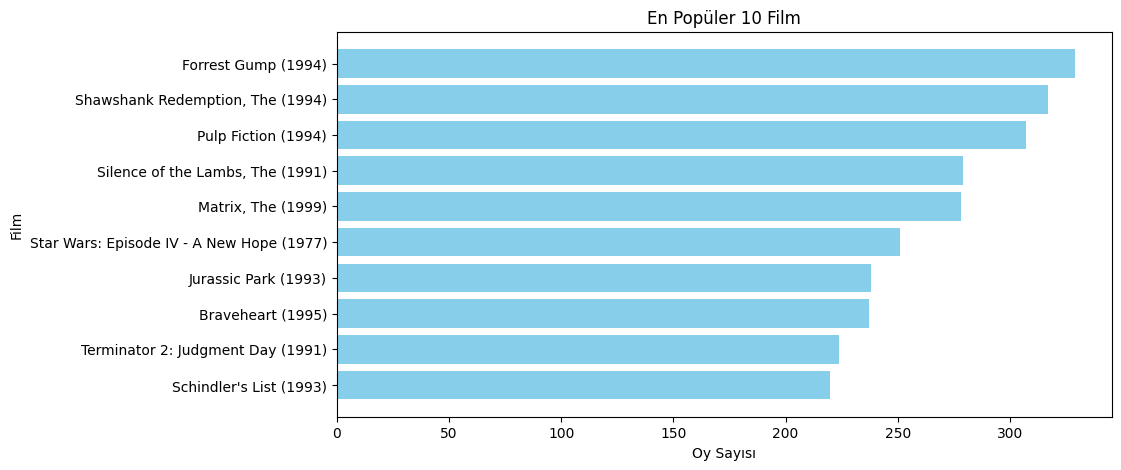

In [10]:
import matplotlib.pyplot as plt

popular_movies = ratings.groupby('movieId')['rating'].count().sort_values(ascending=False).head(10)
popular_movies = popular_movies.reset_index().merge(movies, on='movieId')

plt.figure(figsize=(10,5))
plt.barh(popular_movies['title'], popular_movies['rating'], color='skyblue')
plt.xlabel('Oy Sayısı')
plt.ylabel('Film')
plt.title('En Popüler 10 Film')
plt.gca().invert_yaxis()
plt.show()
